In [2]:
import sktime
import pickle
import gc
import os
import sys
from sklearn.utils import shuffle 
import warnings
from collections import defaultdict
from timeit import default_timer as timer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
from fastai.tabular.core import add_datepart
from sklearn import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, log_loss, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, ParameterGrid,
                                     ParameterSampler, RandomizedSearchCV,
                                     StratifiedKFold, StratifiedShuffleSplit,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from datetime import datetime, timedelta
from sktime.forecasting.arima import ARIMA,AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.var import VAR
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.fbprophet import Prophet
from datetime import datetime, timedelta
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction,MultioutputTimeSeriesRegressionForecaster,DirectTabularRegressionForecaster,MultioutputTabularRegressionForecaster
from sklearn.linear_model import LinearRegression
from sktime.forecasting.model_selection import temporal_train_test_split, SingleWindowSplitter,SlidingWindowSplitter
from statsmodels.tsa.stattools import adfuller
from termcolor import colored
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, ClassifierMixin

C:\Users\sourish.dey\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
train = pd.read_csv('../data/transactions_train.csv.zip')
train['customer_id'] = train['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
train['article_id'] = train.article_id.astype('int32')
train['t_dat'] = pd.to_datetime(train['t_dat'])

#join articles data
products = pd.read_csv('../data/articles.csv.zip')
products_col = ['article_id','product_code','prod_name']
df = pd.merge(train[['t_dat','customer_id','article_id','price', 'sales_channel_id']],products[products_col],on=['article_id'],how='left')


In [814]:
train = pd.read_csv('../data/transactions_train.csv.zip')
train['customer_id'] = train['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
train['article_id'] = train.article_id.astype('int32')
train['t_dat'] = pd.to_datetime(train['t_dat'])

#join articles data
products = pd.read_csv('../data/articles.csv.zip')
products_col = ['article_id','product_code','prod_name']
df = pd.merge(train[['t_dat','customer_id','article_id','price', 'sales_channel_id']],products[products_col],on=['article_id'],how='left')
print(f'unique products: {df.product_code.nunique()}')
print(f'unique customers: {df.customer_id.nunique()}')
df.shape 

unique products: 46834
unique customers: 1362281


(31788324, 7)

### a) Filtering - based on penetration(fraction of customer reach)

In [104]:
custn = df.groupby('product_code')['customer_id'].nunique()
cust = df['customer_id'].nunique()
custn = custn/cust
custn = custn.sort_values(ascending=False)
prod_index_cutoff = list(custn[custn >= 0.1].index)
print(f'eligible product cnt:{len(prod_index_cutoff)}')


eligible product cnt:137


### b) Filtering high sales products - based on cumulative sales fraction(eg. top 257 products consitute 20% of the total sales)

In [103]:

prod_sales = df.groupby('product_code').price.sum()
prod_sales=prod_sales.sort_values(ascending=False)
total_sales = sum(prod_sales)
prod_sales = prod_sales.cumsum()
prod_sales = prod_sales/total_sales
prod_sales = pd.DataFrame(prod_sales)
prod_sales.columns = ['total_sales']
prod_sales['decile'] = pd.cut(prod_sales['total_sales'],bins=10,labels=range(1,11))
display(prod_sales)
#picking top 2 or 3 deciles products for forecasting
top_products_sales = prod_sales[prod_sales.decile < 3]
print(f'eligible product cnt:{len(top_products_sales)}')


,total_sales,decile
product_code,,
706016,0.006642,1
562245,0.011743,1
399201,0.014993,1
568601,0.017930,1
695632,0.020580,1
...,...,...
529551,1.000000,10
619695,1.000000,10
520431,1.000000,10


eligible product cnt:257


### Data preparation

In [16]:
def data_prep(transaction:pd.DataFrame, products:pd.DataFrame, cum_sales_fraction:float=0.0,penetration:float=0.0):

    """
    Over all Data prep function for forecasting.

    Args:
        params: 
            transaction: Dataframe of the purchases each customer for each date with article id(additional information). 
            products: detailed product hierarchy metadata for each article_id available for purchase
            cum_sales_fraction: fraction of cumulative sales for filtering top products  
            penetration:Fraction of unique customers for eligible article_id
    Returns:
        order instance wise Merged and filtered Dataframe with eligible article/products.
    """

    # transaction['customer_id'] = transaction['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    # transaction['article_id'] = transaction.article_id.astype('int32')
    products_col = ['article_id','product_code','prod_name']
    df = pd.merge(transaction[['t_dat','customer_id','article_id','price']],products[products_col],on=['article_id'],how='left')
    if penetration > 0:
        custn = df.groupby('product_code')['customer_id'].nunique()
        cust = df['customer_id'].nunique()
        custn = custn/cust
        custn = custn.sort_values(ascending=False)
        prod_index_cutoff = list(custn[custn >= penetration].index)
        df = df[df.product_code.isin(prod_index_cutoff)]
        print(df.shape)
    if cum_sales_fraction > 0:
        print('entered')
        prod_sales = df.groupby('product_code').price.sum()
        prod_sales=prod_sales.sort_values(ascending=False)
        total_sales = sum(prod_sales)
        prod_sales = prod_sales.cumsum()
        prod_sales = prod_sales/total_sales
        prod_index_cutoff = list(prod_sales[prod_sales <= cum_sales_fraction].index)
        df = df[df.product_code.isin(prod_index_cutoff)]         
    # df['order_instance'] = df['customer_id'].astype(str) + df['t_dat']
    print(f'unique products: {len(prod_index_cutoff)}')
    return df
df = data_prep(transaction = train,products=products,penetration=0.01, cum_sales_fraction=0.0)
print(f'unique customers: {df.customer_id.nunique()}')
df.shape

(5225735, 6)
unique products: 137
unique customers: 857076


(5225735, 6)

### Product level Feature Engineering for modeling

In [656]:
class FeatureProcessor(TransformerMixin,BaseEstimator,RegressorMixin):
    
    """
    Feature Engineering class. Option to make at any aggregation level- daily/weekly(changing 'D' to 'W') etc.

    Args:
        params: 
            X:Product level transaction data

    Returns:
        a) Product level Featurized(date and daily price) data at daily level
    """
    
    def transform(self,X):
        X = self.add_date_feats(X)
        X = self.binarize_cat(X)
        X = self.ohe_cat(X)
        return X

    def add_date_feats(self,X):

        '''Method to extract date features'''

        X = X.rename(columns={'t_dat':'date'})
        # X = pd.DataFrame(X.groupby(['date','product_code'],as_index=False).size())
        # X = X.rename(columns={'size':'sales'})
        X = X.groupby(['product_code','date'],as_index=False).agg({'price':['size','mean']})
        X.columns = ['product_code','date','sales','price']
        X['date'] = pd.to_datetime(X['date'])
        X1 = X[['product_code','date','price']]
        X = X.set_index('date') 
        X = pd.DataFrame(X.resample('D').sales.sum()).reset_index(level='date')
        X = pd.merge(X,X1,on='date',how='inner')
        date = X['date']
        X = add_datepart(X,'date')
        X['date'] = date
        return X

    def binarize_cat(self,X):

        '''Method for binary categorical features'''

        bin_col = ['Is_month_end', 'Is_month_start', 'Is_quarter_end','Is_quarter_start', 'Is_year_end', 'Is_year_start']
        bin = sklearn.preprocessing.LabelBinarizer()
        X[bin_col] = bin.fit_transform(X[bin_col])
        return X

    def ohe_cat(self,X):

        '''Method for onehot encode of categorical features'''

        cat_col = ['Dayofweek','Month']
        ohe = sklearn.preprocessing.OneHotEncoder(sparse=False)
        ohe.fit(X[cat_col])
        x = ohe.transform(X[cat_col])
        x = pd.DataFrame(x)
        x.columns = ohe.get_feature_names_out()
        X = pd.concat([X.drop(cat_col,axis=1).reset_index(drop=True),x],axis=1)  
        return X 

#### Illustration

In [657]:
prod = 507909
fp = FeatureProcessor()
train_feat = fp.transform(df[df.product_code == prod])
train_feat

,sales,product_code,price,Year,Week,Day,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,123,507909,0.024731,2018,38,20,263,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,115,507909,0.024395,2018,38,21,264,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,54,507909,0.025336,2018,38,22,265,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,73,507909,0.024258,2018,38,23,266,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,80,507909,0.024697,2018,39,24,267,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,10,507909,0.024222,2020,38,18,262,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
728,8,507909,0.024400,2020,38,19,263,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
729,6,507909,0.023712,2020,38,20,264,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
730,4,507909,0.023500,2020,39,21,265,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### For consistency only keeping the products which is there in the market for 2 years

In [654]:
df = df.rename(columns={'t_dat':'date'})
duration = pd.DataFrame(df.groupby(['product_code']).agg({'date':['min','max']}).reset_index())
duration.columns = ['_'.join(x) for x in duration.columns.ravel()]
consistent_prods = list(duration[(duration.date_min == '2018-09-20') & (duration.date_max == '2020-09-22')]['product_code_'])
print(f'count of products for long time {len(consistent_prods)}')
df = df[df.product_code.isin(consistent_prods)]
sales_cnt = pd.DataFrame(df.groupby('product_code')['product_code'].count().sort_values(ascending=False))
sales_cnt.head()

,product_code
product_code,
562245,158557
610776,137799
599580,122143
372860,73456
573085,68241


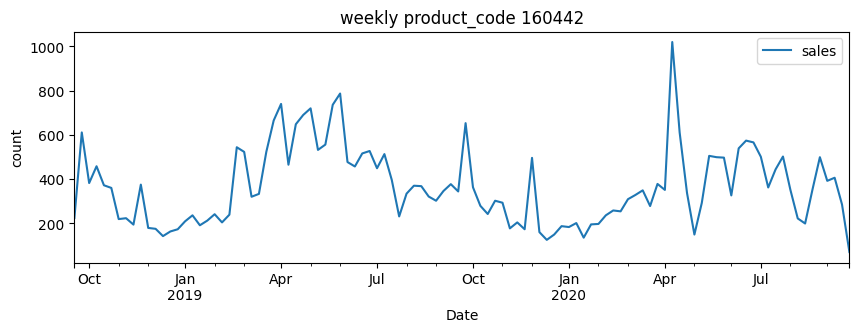

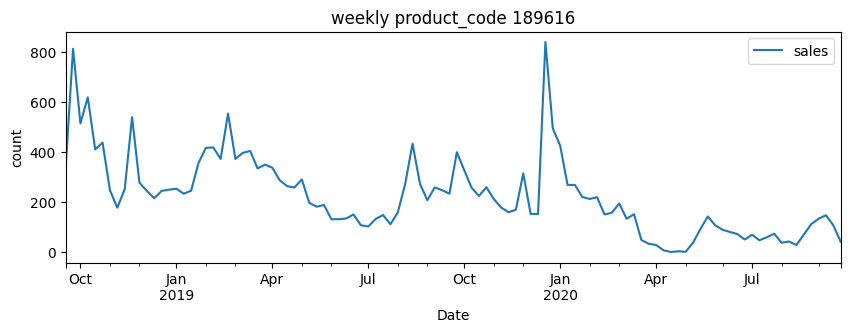

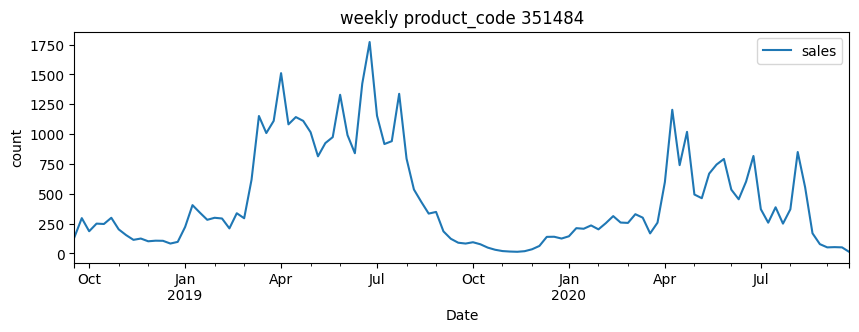

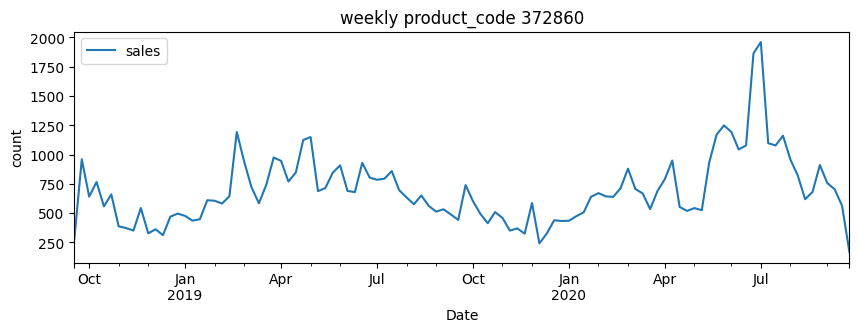

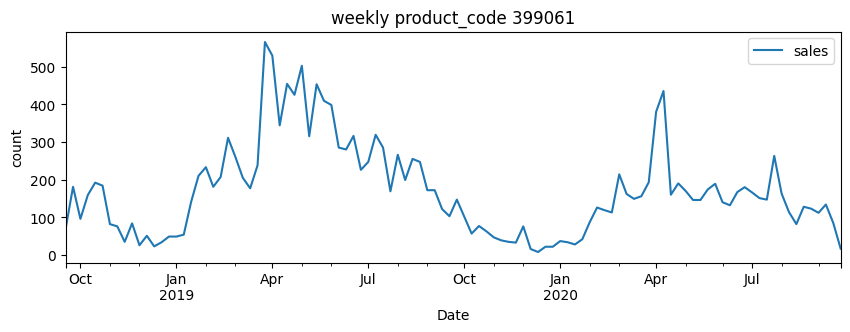

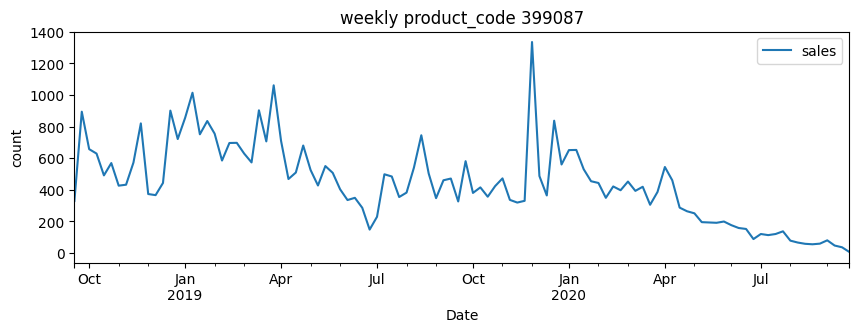

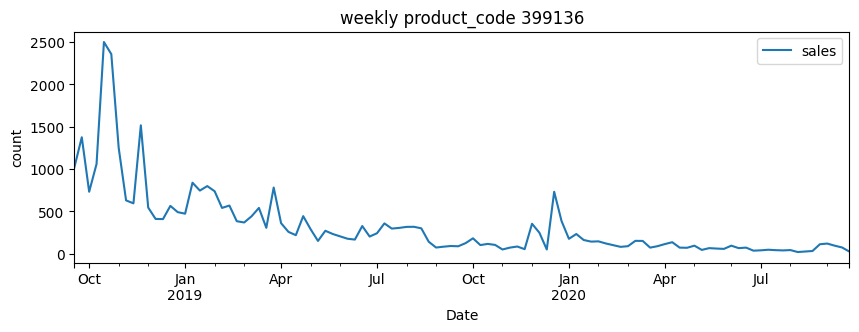

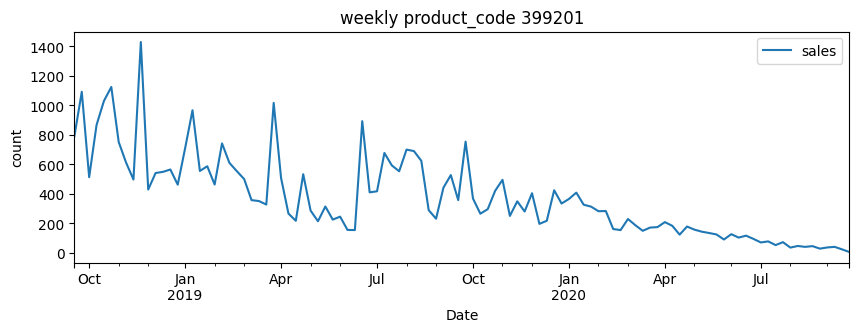

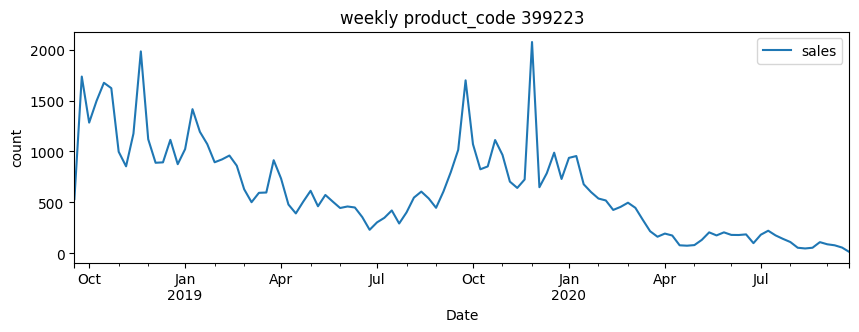

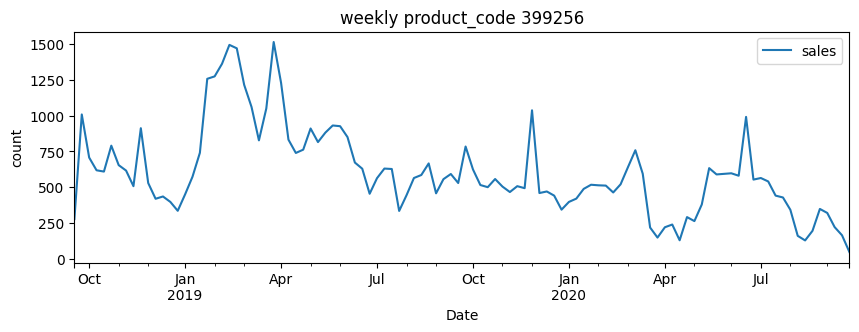

In [340]:
#exploring top 10 products weekly sales
train_feat['date'] = pd.to_datetime(train_feat['date'])
for i in list(consistent_prods)[0:10]:
    train_1 = df[df.product_code == i]
    train_1 = fp.transform(train_1)
    grpd = train_1.groupby('date').agg({'sales':'sum'})
    grpd_weekly = grpd.resample('W').sum()
    y = grpd_weekly.squeeze()
    grpd_weekly.plot(figsize = (10,3), title = f'weekly product_code {i}',xlabel = 'Date',ylabel = 'count')
    

### STL decomposition of weekly sales

'weekly product_code 562245'

'weekly product_code 610776'

'weekly product_code 599580'

'weekly product_code 372860'

'weekly product_code 573085'

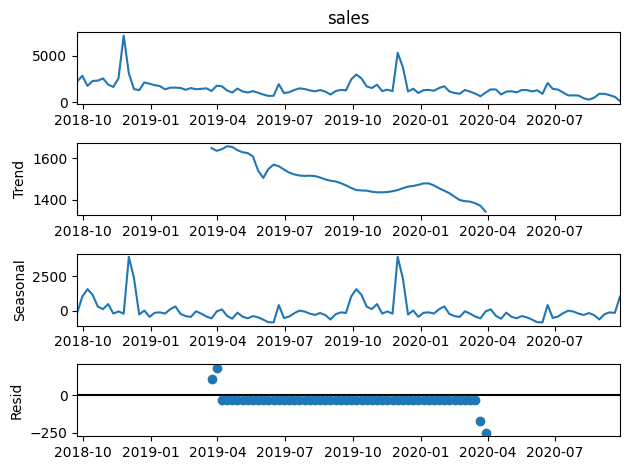

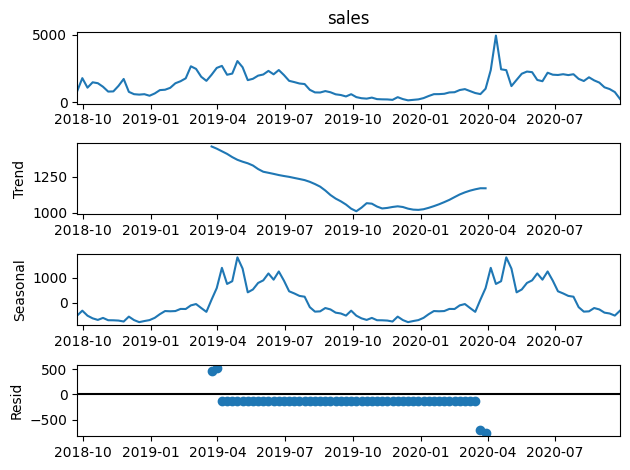

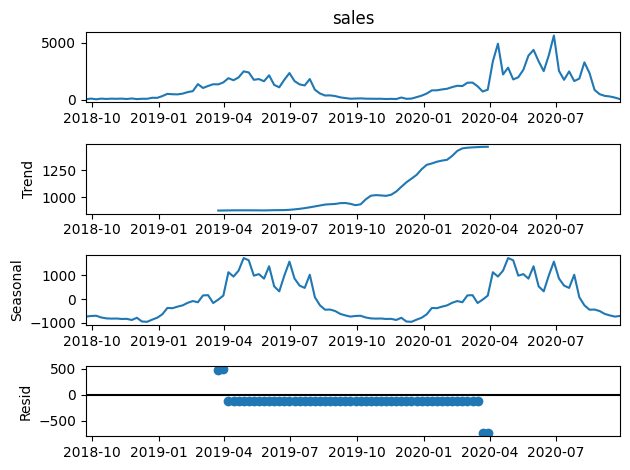

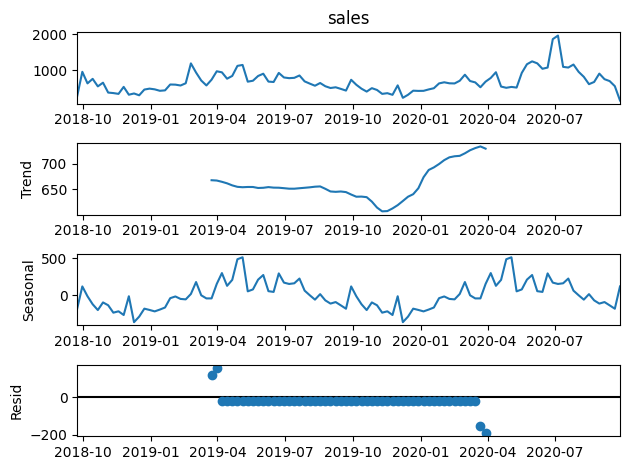

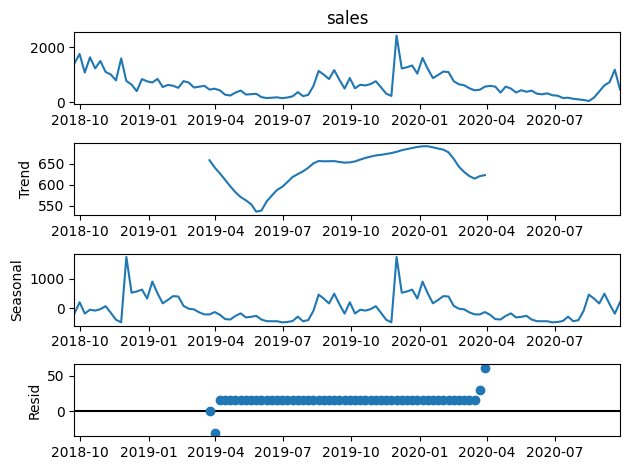

In [776]:
for i in list(sales_cnt.index)[0:5]:
    train_1 = df[df.product_code == i]
    train_1 = fp.transform(train_1)
    grpd = train_1.groupby('date').agg({'sales':'sum'})
    grpd_weekly = grpd.resample('W').sum()
    y = grpd_weekly.squeeze()
    result = seasonal_decompose(y,model='additive')
    display(f'weekly product_code {i}')
    result.plot(result)

### Stationarity Check 

In [798]:
adf_stat = {}
for i in list(sales_cnt.index)[0:5]:
    train_1 = df[df.product_code == i]
    train_1 = fp.transform(train_1)
    grpd = train_1.groupby('date').agg({'sales':'sum'})
    grpd_weekly = grpd.resample('W').sum()
    result = adfuller(grpd_weekly.values.flatten())
    print(colored(f'for product {i}',attrs=['bold']))
    print(f'ADF Statistic: {result[0]}')
    
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    adf_stat[i] = {'pval':result[1],'adf_val':result[0],'critical_value':list(result[4].values())} 
display(adf_stat)

for product 562245
ADF Statistic: -5.73281415677275
p-value: 6.540640422051227e-07
Critial Values:
   1%, -3.4942202045135513
Critial Values:
   5%, -2.889485291005291
Critial Values:
   10%, -2.5816762131519275
for product 610776
ADF Statistic: -3.180693667352162
p-value: 0.02112975817714205
Critial Values:
   1%, -3.4942202045135513
Critial Values:
   5%, -2.889485291005291
Critial Values:
   10%, -2.5816762131519275
for product 599580
ADF Statistic: -3.761368730589699
p-value: 0.003328237380911358
Critial Values:
   1%, -3.502704609582561
Critial Values:
   5%, -2.8931578098779522
Critial Values:
   10%, -2.583636712914788
for product 372860
ADF Statistic: -2.516374930186944
p-value: 0.11154079281363755
Critial Values:
   1%, -3.4954932834550623
Critial Values:
   5%, -2.8900369024285117
Critial Values:
   10%, -2.5819706975209726
for product 573085
ADF Statistic: -2.779717655147836
p-value: 0.06122987146123975
Critial Values:
   1%, -3.4954932834550623
Critial Values:
   5%, -2.890

{562245: {'pval': 6.540640422051227e-07,
  'adf_val': -5.73281415677275,
  'critical_value': [-3.4942202045135513,
   -2.889485291005291,
   -2.5816762131519275]},
 610776: {'pval': 0.02112975817714205,
  'adf_val': -3.180693667352162,
  'critical_value': [-3.4942202045135513,
   -2.889485291005291,
   -2.5816762131519275]},
 599580: {'pval': 0.003328237380911358,
  'adf_val': -3.761368730589699,
  'critical_value': [-3.502704609582561,
   -2.8931578098779522,
   -2.583636712914788]},
 372860: {'pval': 0.11154079281363755,
  'adf_val': -2.516374930186944,
  'critical_value': [-3.4954932834550623,
   -2.8900369024285117,
   -2.5819706975209726]},
 573085: {'pval': 0.06122987146123975,
  'adf_val': -2.779717655147836,
  'critical_value': [-3.4954932834550623,
   -2.8900369024285117,
   -2.5819706975209726]}}

#### For few products series is not stationary, so may have to make the time series closer to being stationary may have to deseasonalize and detrend during forecasting pipeline.

#### Relationship with Price

In [562]:
price = df.groupby('product_code').agg({'price':['max','min','std','mean']})
price.head()

price                              
                   max       min       std      mean
product_code                                        
160442        0.013542  0.000831  0.001242  0.012926
189616        0.016932  0.000763  0.003241  0.015061
351484        0.022017  0.000831  0.004079  0.019734
372860        0.013542  0.001339  0.002357  0.012213
399061        0.059305  0.003051  0.009445  0.053952

C:\Users\sourish.dey\AppData\Local\Temp\ipykernel_28332\269788377.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  price.columns = ['_'.join(x) for x in price.columns.ravel()]


,product_code_,date_,sales,price_mean
0,160442,2018-09-20,61,0.013382
1,160442,2018-09-21,72,0.013505
2,160442,2018-09-22,46,0.013542
3,160442,2018-09-23,45,0.013531
4,160442,2018-09-24,35,0.013465


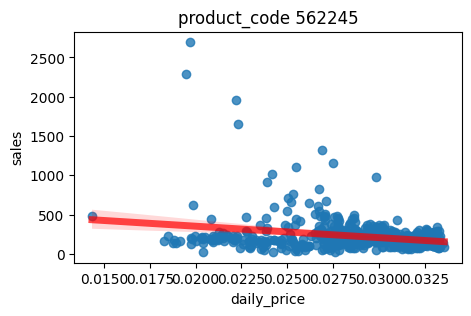

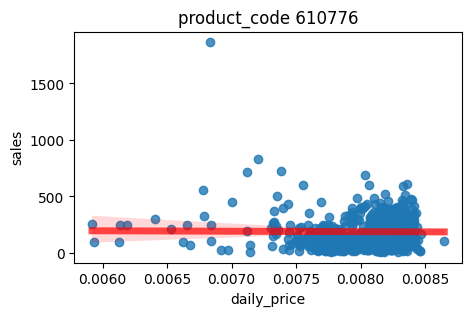

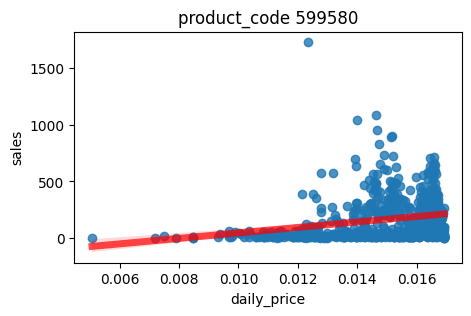

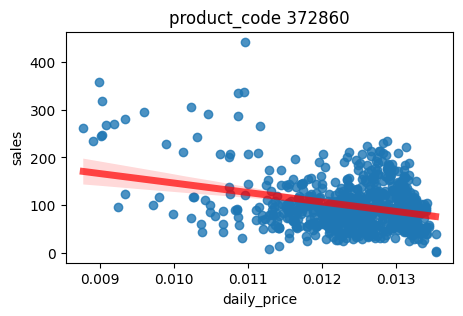

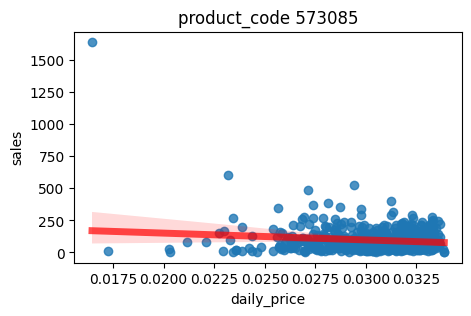

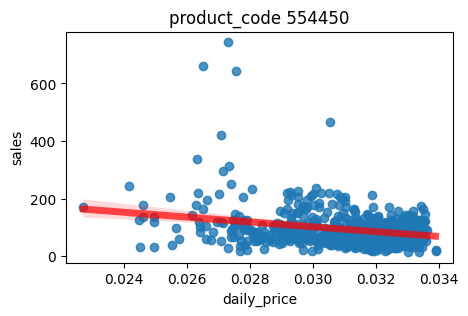

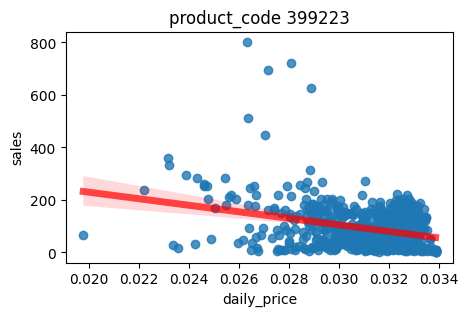

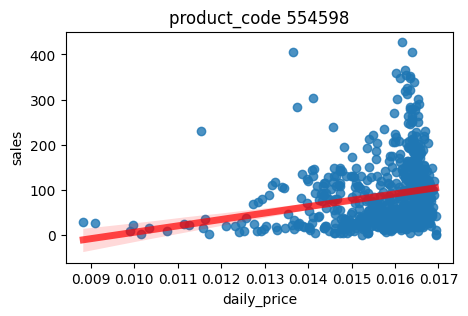

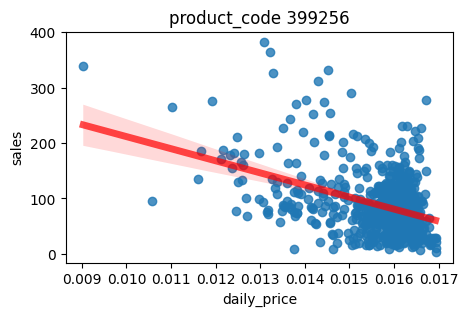

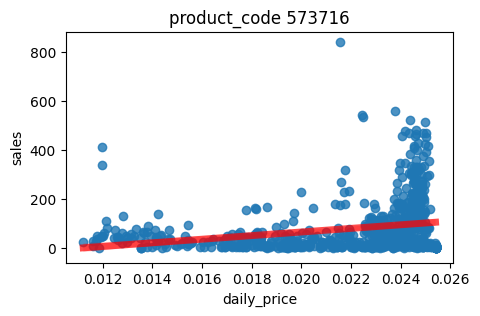

In [595]:
price = df.groupby(['product_code','date'],as_index=False).agg({'price':['size','mean']})
price.columns = ['_'.join(x) for x in price.columns.ravel()]
price = price.rename(columns = {'price_size':'sales'})
display(price.head())
import scipy as sp
for i in list(sales_cnt.index)[0:10]:
    temp = price[price.product_code_ == i][['price_mean','sales']]
    fig, ax = plt.subplots()
    fig.set_size_inches(5,3)
    sns.regplot(x=temp.price_mean, y=temp.sales, line_kws={"color":"r","alpha":0.7,"lw":5})
    plt.title(f'product_code {i}')
    plt.xlabel("daily_price")
    plt.ylabel("sales")
    plt.show()


- Not all the products show monotonically decreasing relationship of sales w.r.t. price. Fashion items are seasonal and also has short life cycles and high volatility

## Time Series Forecasting
### Design
 - A) Product specific Models
 - B) Unit of data- Daily level
 - C) With approx. 2 years of data, forecasting is for last 2 weeks(14 days) and model trained on rest of the data(for each product)
 - For quick implementation assume quarterly and additive seasonality and Polynomial trend of degree 1
 - I used TransformedTargetForecaster from sktime to build Forecasting pipeline using default XGBoost as regressor
 
 ### Assumption
  - A) Daily price will be available during forecasting period
  - B) Alternatively next day forecasting can be done based on last day price level

#### Features

In [647]:
x_feats = ['Year', 'Week', 'Day', 'Dayofyear','price',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Dayofweek_0',
       'Dayofweek_1', 'Dayofweek_2', 'Dayofweek_3', 'Dayofweek_4',
       'Dayofweek_5', 'Dayofweek_6', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12']
target = 'sales'

In [25]:
class Model_train_prediction(TransformerMixin,RegressorMixin,BaseEstimator):

    '''Class for building model and prediction including evaluation
        Input: Product level Featurized data at daily level
    '''
    
    def __init__(self,window_len, test_size,path):

       '''test_size- Period of Forecasting(2 weeks)
          window_len- number of lags sliding window transformation  
       ''' 
       self.test_size = test_size 
       self.window_len = window_len
       self.path = path
       if not os.path.exists(self.path):
            os.makedirs(self.path)


    def data_prep(self,data):

        '''Method to create train and test data'''

        X = data[x_feats]
        Y = train_feat[[target]]
        date = data['date']
        train_y, test_y,train_x, test_x = temporal_train_test_split(y=Y,X=X,test_size=self.test_size)
        return train_y, test_y,train_x, test_x

    def model_train(self,train_x, train_y,test_y):

        '''Method to train Model using grid search'''

        fh = ForecastingHorizon(values=test_y.index,is_relative=False)
        regressor = xgb.XGBRFRegressor(objective='reg:squarederror', random_state=42)
        forecaster = MultioutputTabularRegressionForecaster(estimator=regressor,window_length=self.window_len)
        # forecaster = TransformedTargetForecaster([
        # ("deseasonalize",Deseasonalizer(model="additive",sp = 90)),
        # ("dtrend",Detrender(forecaster = PolynomialTrendForecaster(degree=1))),
        # ("forecast", MultioutputTabularRegressionForecaster(estimator=regressor,window_length=self.window_len)),
    # ])
        forecaster.fit(y=train_y,X=train_x,fh = fh)
        return forecaster,fh

    def make_forecast(self,forecaster,test_x,fh):

        '''Method for Forecasting'''

        pred_y = round(forecaster.predict(X = test_x,fh = fh),0)
        return pred_y

    def evaluate(self,test_y,pred_y):

        '''Method to evaluate Forecasting result'''
        
        mape = sklearn.metrics.mean_absolute_percentage_error(test_y,pred_y)
        return mape

In [927]:
path = '../models'
mape = {}
prediction = {}
actual = {}
if __name__ == '__main__':
    mtp = Model_train_prediction(window_len=30, test_size=14,path = path)
    for i in consistent_prods:
        fp = FeatureProcessor()
        train_feat = fp.transform(df[df.product_code==i])
        train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
        forecaster,fh = mtp.model_train(train_x, train_y,test_y)
        with open(os.path.join(path, f'item_{i}.pkl'),'wb') as f:
            pickle.dump(forecaster,f)
        pred_y = mtp.make_forecast(forecaster,test_x,fh)
        prediction[i] = list(pred_y.sales.values)
        actual[i] = list(test_y.sales.values)
        try:
            mape[i] = mtp.evaluate(test_y,pred_y)
        except:
            mape[i]: ZeroDivisionError
    actuals = pd.DataFrame(actual)
    actuals.columns = [f'actual_{i}' for i in actual.keys()]
    predictions = pd.DataFrame(prediction)
    predictions.columns = [f'prediction_{i}' for i in prediction.keys()]
    acutal_prediction = pd.concat([actuals,predictions],axis=1)
    print(mape)
    print(acutal_prediction.head())
    acutal_prediction.to_csv(os.path.join(path, 'acutal_prediction.csv'),index=False)           

{160442: 0.41946976261921975, 189616: 0.8597373276159767, 351484: 1.426218820861678, 372860: 0.30821997353418235, 399061: 0.46833651562910056, 399087: 1.7229308390022677, 399136: 1.1145535486922042, 399201: 1.7285714285714284, 399223: 28.998863636363634, 399256: 1.062481716919057, 429313: 2.9030612244897958, 448509: 0.33264099796407987, 456163: 0.35187649819460776, 464297: 6.894771498342927, 507909: 2.4251534180105607, 516000: 0.5639199911756303, 519583: 1.1178571428571427, 524529: 0.32414965986394556, 536139: 1.335987385128424, 547780: 0.24471755673161577, 554450: 0.4389430180829191, 554479: 4.023809523809524, 554598: 0.23487518946536504, 556539: 0.29941234050998994, 559616: 2.9345238095238093, 559630: 8.932544836116264, 562245: 1.0133696306202788, 568597: 0.9454287026681432, 568601: 0.5528211245377052, 572797: 0.3656616931688191, 573085: 0.3319836037920546, 573716: 2.9720238095238094, 574109: 2.6180932068637333, 579541: 0.22743744948254369, 589599: 8.130952380952381, 590928: 0.740221

In [24]:
model_path = '../models/'
path = '../forecast1/'
data_path = '../data/'
prediction = pd.DataFrame()
if __name__ == '__main__':
    test_df = pd.read_csv(os.path.join(data_path,'test_data.csv'))
    with open(os.path.join(model_path,'prod_dict.p'), 'rb') as fp:
        prod_dict = pickle.load(fp) 
    for i in list(prod_dict.keys())[0:2]:
        print(i)
        test_x = test_df[test_df.product_code == i]
        prod_mod_path = os.path.join(model_path,f'item_{i}.pkl')
        mi = Model_Inference(model_path=prod_mod_path)
        model,test_x = mi.collect_data_model(test_x)
        pred = mi.make_forecast(model,test_x)
        print(list(pred.reshape(-1,1)))
        pred = pd.DataFrame({'prod':prod_dict[i],'forecast':pred.values, 'day':list(range(1,15))})

[507909,
 611415,
 673677,
 448509,
 610776,
 562245,
 568597,
 399136,
 573085,
 568601,
 591334,
 573716,
 519583,
 456163,
 399087,
 464297,
 351484,
 559630,
 399201,
 579541,
 660599,
 621381,
 554450,
 624486,
 658030,
 640021,
 574109,
 664074,
 524529,
 399223,
 673396,
 677930,
 664319,
 516000,
 372860,
 160442,
 189616,
 608776,
 399256,
 554598,
 536139,
 636323,
 683001,
 599580,
 554479,
 678942,
 399061,
 589599,
 547780,
 572797,
 429313,
 600886,
 590928,
 688558,
 559616,
 711053,
 556539]

In [23]:
prod_name = list(df.prod_name.unique())
product_code = list(df.product_code.unique())
prod_dict = {k:v for (k,v) in zip(product_code,prod_name)}
with open('../models/prod_dict.p', 'wb') as fp:
    pickle.dump(prod_dict, fp)
       

### Forcasting Performance

Text(0.5, 1.0, 'for product Nora T-shirt')

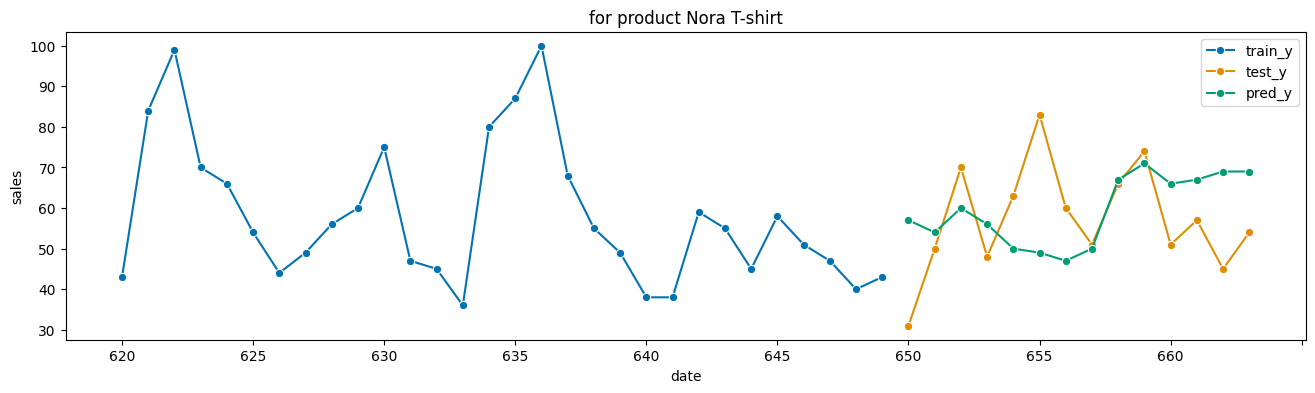

In [855]:
from sktime.utils.plotting import plot_series
plot_series(train_y[-30:], test_y, pred_y, labels = ['train_y','test_y','pred_y'],x_label = 'date',y_label = 'sales')
plt.title(f'for product {prod_dict[i]}')

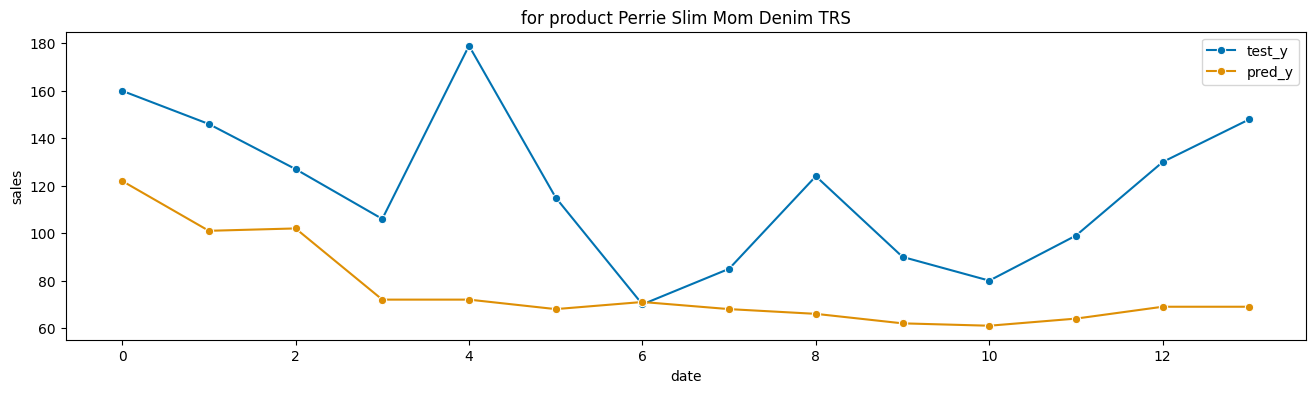

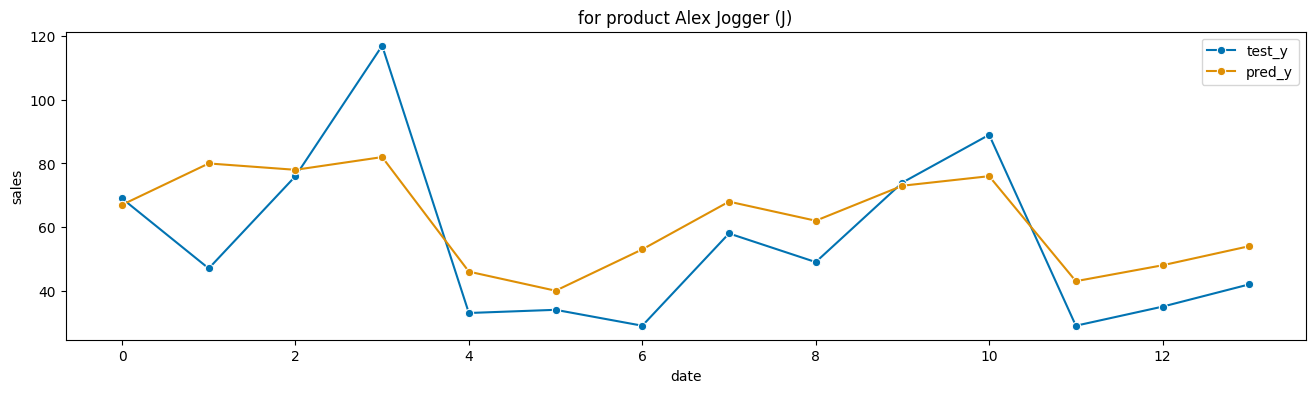

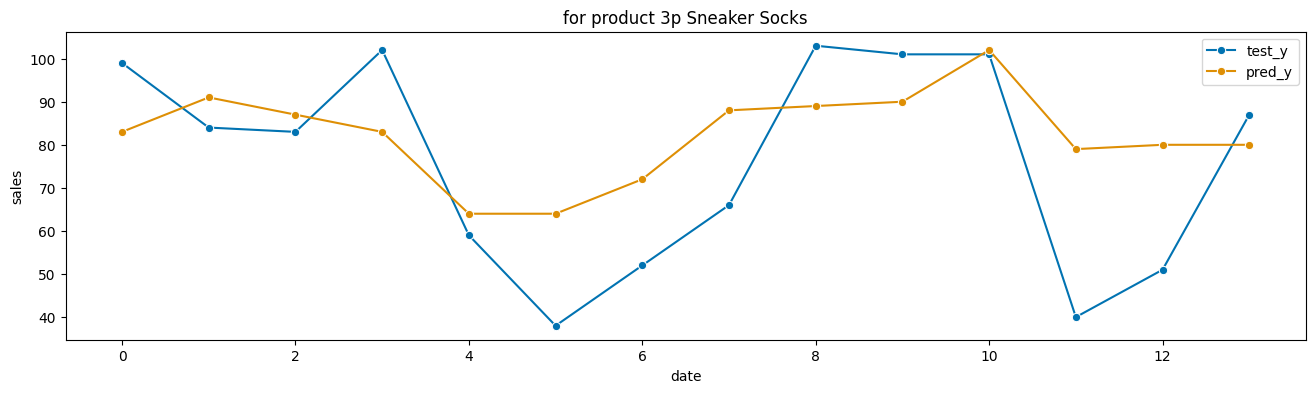

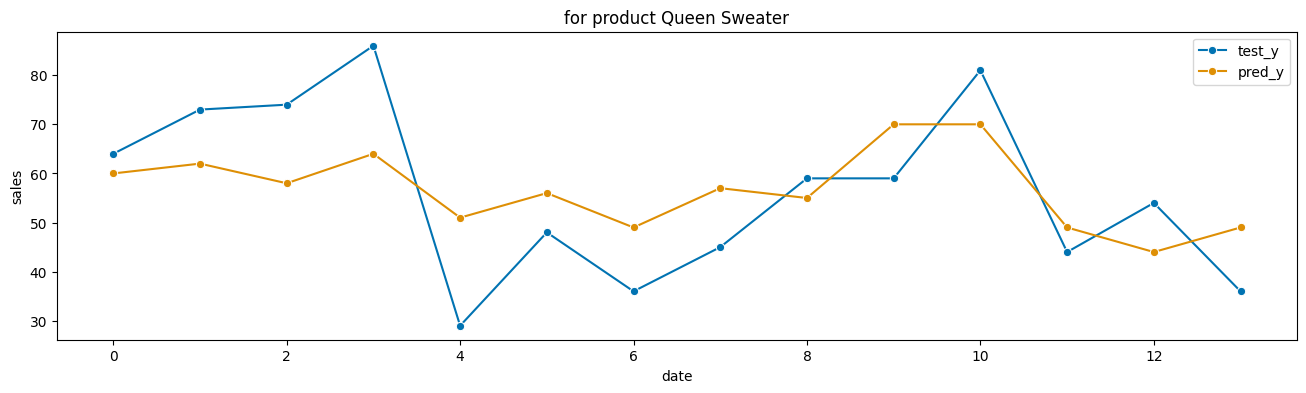

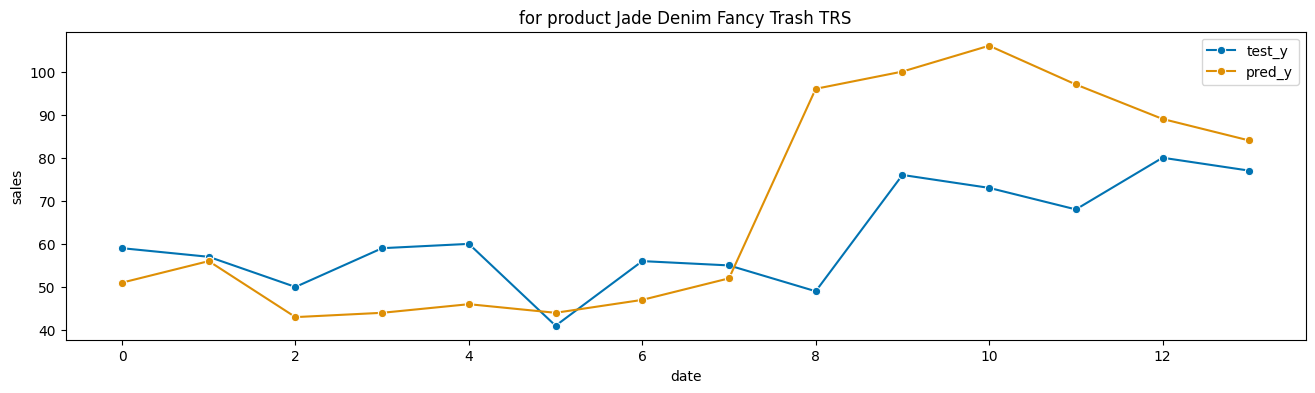

In [928]:
code = [448509,556539,678942,554598,547780]
for prod in code:
    test_y = actual[prod]
    pred_y = prediction[prod]
    plot_series(pd.Series(test_y), pd.Series(pred_y), labels = ['test_y','pred_y'],x_label = 'date',y_label = 'sales')
    plt.title(f'for product {prod_dict[prod]}')

### Inference pipeline

#### preparing data to be used during inference time
 - As there is no prediction data using test_x(last 14 days) as unknown data  

In [870]:
test_df = pd.DataFrame()
for i in consistent_prods:
    fp = FeatureProcessor()
    train_feat = fp.transform(df[df.product_code==i])
    train_y, test_y,train_x, test_x = mtp.data_prep(train_feat)
    test_x['product_code'] = i
    test_df = test_df.append(test_x)
test_df.to_csv('../data/test_data.csv',index=False)    
    

In [26]:
class Model_Inference(TransformerMixin,RegressorMixin,BaseEstimator):

    '''Class for using model for prediction
        Input: Featurized data at daily level
    '''
    def __init__(self,model_path):

       self.model_path = model_path 

    def collect_data_model(self,data):
        test_x = data.drop('product_code',axis=1)
        with open(self.model_path ,'rb') as fout:
            model= pickle.load(fout)
        return model,test_x    

    def make_forecast(self,model,test_x):

        '''Method for Forecasting'''

        pred_y = round(model.predict(fh = model.fh),0)
        return pred_y



In [912]:
path = '../forecast/'
model_path = '../models/'
prediction = pd.DataFrame()
if __name__ == '__main__':
    for i in consistent_prods:
        print(i)
        test_x = test_df[test_df.product_code == i]
        prod_mod_path = os.path.join(model_path,f'item_{i}.pkl')
        mi = Model_Inference(model_path=prod_mod_path)
        model,test_x = mi.collect_data_model(test_x)
        pred = mi.make_forecast(model,test_x)
        pred = pd.DataFrame({'prod':prod_dict[i],'forecast':pred, 'day':list(range(1,15))})
        if not os.path.exists(path):
            os.makedirs(path)
        pred.to_csv(os.path.join(path,f'item_{i}.csv'),index=False)
        prediction = prediction.append(pred)
    prediction.to_csv(os.path.join(path,'all_product_prediction.csv'),index=False)    
        